# Analyzing Cisplatin-Binding Transcripts via GLM-SAE Knowledge Graphs

In [13]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from networkx.readwrite import json_graph

import os, json

with open("data/cisplatin_pos_kg.json") as f:
    data = json.load(f)

G: nx.MultiDiGraph = json_graph.node_link_graph(data, edges="edges")
print(G)

MultiDiGraph with 6172 nodes and 848782 edges


In [14]:
# graph is large, so lets trim down a version we can visualize
OG = G.copy()

# filter features that only respond to one token
to_remove = [n for n in G.nodes if G.in_degree(n) == 1]
G.remove_nodes_from(to_remove)
print(G)

# the '<cls>' token is the 'start' token and does not encode genetic info
if G.has_node('<cls>'):
    G.remove_node('<cls>')
    print(G)

# find average edge bundle size
edge_sizes = {(u,v): len(G.get_edge_data(u, v)) for u, v, k in G.edges}
avg_edge_size = sum(edge_sizes.values()) / len(edge_sizes)
print(f"Average edge bundle size: {avg_edge_size}")
print(f"Median edge bundle size: {np.median(list(edge_sizes.values()))}")
print(f"Number of edge bundles: {len(edge_sizes)}")
print(f"Max edge bundle size: {max(edge_sizes.values())}")
print(f"Min edge bundle size: {min(edge_sizes.values())}")
print(f"Standard deviation of edge bundle sizes: {pd.Series(edge_sizes.values()).std()}")

# filter edges that have less than 5 samples in their bundle, then show new descriptive stats
print("---------- Filtering edges with less than 5 samples in their bundle ----------")
to_remove = [key for key, size in edge_sizes.items() if size < 5]
for ebundle in to_remove:
    u, v = ebundle
    keys = list(G.get_edge_data(u, v).keys())
    for k in keys:
        G.remove_edge(u, v, k)
# G.remove_edges_from(to_remove)
print(G)

edge_sizes = {(u,v): len(G.get_edge_data(u, v)) for u, v, k in G.edges}
avg_edge_size = sum(edge_sizes.values()) / len(edge_sizes)
print(f"Average edge bundle size: {avg_edge_size}")
print(f"Median edge bundle size: {np.median(list(edge_sizes.values()))}")
print(f"Number of edge bundles: {len(edge_sizes)}")
print(f"Max edge bundle size: {max(edge_sizes.values())}")
print(f"Min edge bundle size: {min(edge_sizes.values())}")
print(f"Standard deviation of edge bundle sizes: {pd.Series(edge_sizes.values()).std()}")

# re-filter features that only respond to one token or are disconnected from the graph
to_remove = [n for n in G.nodes if G.in_degree(n) <= 1 and type(n) == int]
G.remove_nodes_from(to_remove)
print(G)

MultiDiGraph with 5879 nodes and 848489 edges
MultiDiGraph with 5878 nodes and 804654 edges
Average edge bundle size: 5.4587231271242205
Median edge bundle size: 1.0
Number of edge bundles: 147407
Max edge bundle size: 8785
Min edge bundle size: 1
Standard deviation of edge bundle sizes: 51.929513896535106
---------- Filtering edges with less than 5 samples in their bundle ----------
MultiDiGraph with 5878 nodes and 628643 edges
Average edge bundle size: 23.83480568720379
Median edge bundle size: 10.0
Number of edge bundles: 26375
Max edge bundle size: 8785
Min edge bundle size: 5
Standard deviation of edge bundle sizes: 121.06815764725847
MultiDiGraph with 4847 nodes and 628643 edges


In [15]:
# use annotations to create two graphs of coding and non-coding genomic regions
coding_regions = [e for e in G.edges(data=True, keys=True) if len(e[3]["annotations"]) != 0]
non_coding_regions = [e for e in G.edges(data=True, keys=True) if len(e[3]["annotations"]) == 0]

G_coding = nx.MultiDiGraph()
for edge in coding_regions:
    G_coding.add_edge(edge[0], edge[1], edge[2], **edge[3])
G_non_coding = nx.MultiDiGraph()
for edge in non_coding_regions:
    G_non_coding.add_edge(edge[0], edge[1], edge[2], **edge[3])

print(f"Coding graph: {G_coding}")
print(f"Non-coding graph: {G_non_coding}")

Coding graph: MultiDiGraph with 4259 nodes and 57857 edges
Non-coding graph: MultiDiGraph with 4819 nodes and 570786 edges


In [16]:
def node_color(x):
    return "lightblue" if type(x) == str else "red"

In [17]:
print("--- CODING SEQUENCES ---")

pagerank = nx.pagerank(G_coding)
sorted_pr = sorted(pagerank.items(), key=lambda item: item[1], reverse=True)
print("Top 10 nodes by PageRank:")
for node, pr in sorted_pr[:10]:
    print(f"Node: {node}, PageRank: {pr}")

degree_centrality = nx.out_degree_centrality(G_coding)
sorted_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)
print("Top 10 nodes by Out-Degree Centrality:")
for node, dc in sorted_degree[:10]:
    print(f"Node: {node}, Out-Degree Centrality: {dc}")

#nx.draw(G_coding, pos=nx.forceatlas2_layout(G_coding), with_labels=False, node_size=10, font_size=4, node_color=[node_color(n) for n in G_coding.nodes()])

--- CODING SEQUENCES ---
Top 10 nodes by PageRank:
Node: 3378, PageRank: 0.0954266669857938
Node: 4793, PageRank: 0.08614907113905293
Node: 407, PageRank: 0.061096425645242314
Node: 2558, PageRank: 0.03625600953741979
Node: 1545, PageRank: 0.023343081013678275
Node: 7612, PageRank: 0.012794219706204188
Node: 4014, PageRank: 0.012123968309706341
Node: 6445, PageRank: 0.011541107115998062
Node: 8707, PageRank: 0.009984743551191775
Node: 5234, PageRank: 0.006128120327257333
Top 10 nodes by Out-Degree Centrality:
Node: G, Out-Degree Centrality: 0.678252700798497
Node: C, Out-Degree Centrality: 0.646782527007985
Node: A, Out-Degree Centrality: 0.5441521841240019
Node: T, Out-Degree Centrality: 0.5345232503522781
Node: GCCGCC, Out-Degree Centrality: 0.02912165335838422
Node: CCGCCG, Out-Degree Centrality: 0.02747768905589479
Node: CGCCGC, Out-Degree Centrality: 0.025129168623767028
Node: GAGGAG, Out-Degree Centrality: 0.022545796148426493
Node: GGCGGC, Out-Degree Centrality: 0.02160638797557

In [18]:
print("--- NON-CODING SEQUENCES ---")

pagerank = nx.pagerank(G_non_coding)
sorted_pr = sorted(pagerank.items(), key=lambda item: item[1], reverse=True)
print("Top 10 nodes by PageRank:")
for node, pr in sorted_pr[:10]:
    print(f"Node: {node}, PageRank: {pr}")

degree_centrality = nx.out_degree_centrality(G_non_coding)
sorted_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)
print("Top 10 nodes by Out-Degree Centrality:")
for node, dc in sorted_degree[:10]:
    print(f"Node: {node}, Out-Degree Centrality: {dc}")


#nx.draw(G_non_coding, pos=nx.forceatlas2_layout(G_non_coding), with_labels=False, node_size=10, font_size=4, node_color=[node_color(n) for n in G_non_coding.nodes()])

--- NON-CODING SEQUENCES ---
Top 10 nodes by PageRank:
Node: 4793, PageRank: 0.08619088307944313
Node: 3378, PageRank: 0.08197376340176783
Node: 407, PageRank: 0.06606307825285299
Node: 2558, PageRank: 0.03135147332159834
Node: 1545, PageRank: 0.02090430544453861
Node: 6445, PageRank: 0.011221303671365012
Node: 4014, PageRank: 0.010348503106505865
Node: 7612, PageRank: 0.010329536147393735
Node: 8707, PageRank: 0.009763513600654507
Node: 5234, PageRank: 0.0055785592500795
Top 10 nodes by Out-Degree Centrality:
Node: C, Out-Degree Centrality: 5.712121212121212
Node: G, Out-Degree Centrality: 5.5226234952262345
Node: T, Out-Degree Centrality: 4.909713574097136
Node: A, Out-Degree Centrality: 4.7339144873391446
Node: CCTCCC, Out-Degree Centrality: 0.2254047322540473
Node: TTTTTT, Out-Degree Centrality: 0.17393109173931093
Node: GCCTCC, Out-Degree Centrality: 0.1631382316313823
Node: CCCAGC, Out-Degree Centrality: 0.15960979659609797
Node: CTCCTG, Out-Degree Centrality: 0.1552511415525114


In [19]:
# COMPARE TO ORIGINAL GRAPH
# use page rank to measure centrality
pagerank = nx.pagerank(OG)
sorted_pagerank = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)

print("Nodes ranked by PageRank:")
for node, score in sorted_pagerank[:10]:  # top 10 nodes
    print(f"{node}: {score}")

Nodes ranked by PageRank:
3378: 0.05591438534474252
4793: 0.04776315882634009
407: 0.04058334611930585
2558: 0.02174499892379862
1545: 0.014473227554864115
7612: 0.009225784115039545
6445: 0.00832866187503917
8707: 0.008153740563806095
4014: 0.00770609877987153
9685: 0.005610925728333565


In [20]:
# COMPARE TO ORIGINAL GRAPH
# compare with degree centrality for important tokens
degree_centrality = nx.out_degree_centrality(OG)
sorted_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)

print("Nodes ranked by Degree Centrality:")
for node, score in sorted_degree[:10]:  # top 10 nodes
    print(f"{node}: {score}")

Nodes ranked by Degree Centrality:
<cls>: 7.103386809269162
C: 5.001782531194296
G: 4.875384864689678
T: 4.280343542375628
A: 4.147139847674607
CCTCCC: 0.19850915572840708
TTTTTT: 0.1523253929671042
GCCTCC: 0.15119105493437043
CCCAGC: 0.14584346135148274
GCCGCC: 0.14195430238210988


In [21]:
# export to cytoscape for visualization
# Didn't work for the large graph, so just keeping for documentation
for node in OG.nodes():
    OG.nodes[node]['id'] = node

cyto_data = nx.readwrite.json_graph.cytoscape_data(OG)
with open("data/cisplatin_pos_kg_cyto.json", "w") as f:
    json.dump(cyto_data, f)

# Using Knowledge Graph Patterns to Create Gene Sets

Note the strong centrality in multiple segments of the graph for features 3378, 407, and 4793, as well as typical base pairing hairpin motifs with high GC content in the outbound central nodes. 

By gathering data from the edges associated with each major feature, we can create gene sets based on GLM feature output. 

In [22]:
# Note that our non-coding graph lacks annotations by definition, so we will only create gene sets for coding regions
# 3378
edges = G_coding.in_edges(3378, data="annotations")

genes = []
motifs = []
for u, v, annotations in edges:
    for key, val in annotations.items():
        genes.append(val["gene_id"])
        motifs.append(u)

os.makedirs("data/gene_sets", exist_ok=True)

with open("data/gene_sets/feature_3378_genes.txt", "w") as f:
    f.write("\n".join(set(genes)))

with open("data/gene_sets/feature_3378_motifs.txt", "w") as f:
    f.write("\n".join(set(motifs)))

# 407
edges = G_coding.in_edges(407, data="annotations")

genes = []
motifs = []
for u, v, annotations in edges:
    for key, val in annotations.items():
        genes.append(val["gene_id"])
        motifs.append(u)

with open("data/gene_sets/feature_407_genes.txt", "w") as f:
    f.write("\n".join(set(genes)))

with open("data/gene_sets/feature_407_motifs.txt", "w") as f:
    f.write("\n".join(set(motifs)))


# 4793
edges = G_coding.in_edges(4793, data="annotations")

genes = []
motifs = []
for u, v, annotations in edges:
    for key, val in annotations.items():
        genes.append(val["gene_id"])
        motifs.append(u)

with open("data/gene_sets/feature_4793_genes.txt", "w") as f:
    f.write("\n".join(set(genes)))

with open("data/gene_sets/feature_4793_motifs.txt", "w") as f:
    f.write("\n".join(set(motifs)))


# Community Detection

In [23]:
# Louvain
communities = nx.community.louvain_communities(OG.to_undirected(), resolution=1.5)
print(f"Found {len(communities)} communities")

Found 18 communities


Community 0:
 Central Features (In-Degree Centrality):
  Node: 5746, In-Degree Centrality: 43835.0
  Node: <cls>, In-Degree Centrality: 0.0
 Central Motifs (Out-Degree Centrality):
  Node: <cls>, Out-Degree Centrality: 43835.0
  Node: 5746, Out-Degree Centrality: 0.0


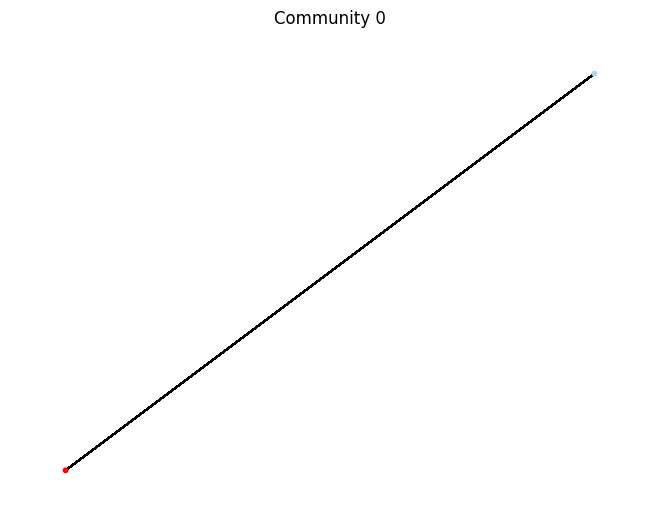

Community 1:
 Central Features (In-Degree Centrality):
  Node: 3378, In-Degree Centrality: 109.61040609137055
  Node: 6940, In-Degree Centrality: 0.5126903553299492
  Node: 7779, In-Degree Centrality: 0.4809644670050761
  Node: 1445, In-Degree Centrality: 0.3375634517766497
  Node: 4692, In-Degree Centrality: 0.15989847715736039
 Central Motifs (Out-Degree Centrality):
  Node: CCTCCC, Out-Degree Centrality: 1.2715736040609136
  Node: CTCCTG, Out-Degree Centrality: 0.9505076142131978
  Node: CCTCCT, Out-Degree Centrality: 0.8895939086294415
  Node: CTCCTC, Out-Degree Centrality: 0.7880710659898477
  Node: CCTGCC, Out-Degree Centrality: 0.7538071065989848


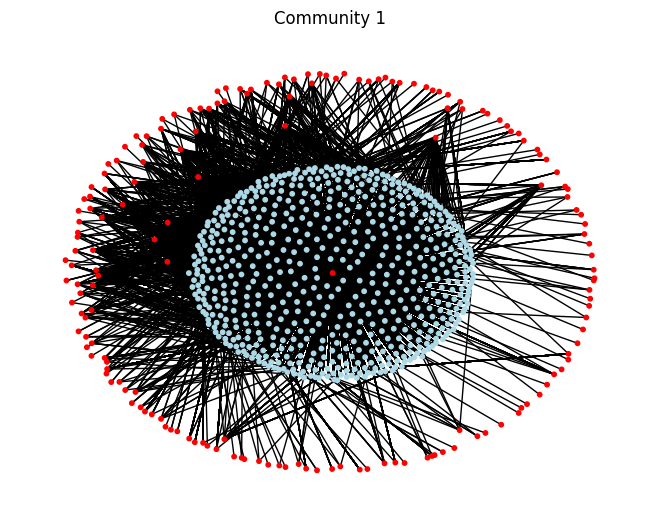

Community 2:
 Central Features (In-Degree Centrality):
  Node: 7612, In-Degree Centrality: 15.035320088300221
  Node: 1299, In-Degree Centrality: 4.3509933774834435
  Node: 6371, In-Degree Centrality: 2.2008830022075054
  Node: 6110, In-Degree Centrality: 2.0573951434878586
  Node: 9341, In-Degree Centrality: 1.17439293598234
 Central Motifs (Out-Degree Centrality):
  Node: CAGCAG, Out-Degree Centrality: 0.6843267108167771
  Node: CAGCTC, Out-Degree Centrality: 0.6777041942604857
  Node: CACCTC, Out-Degree Centrality: 0.6335540838852097
  Node: CAGCAC, Out-Degree Centrality: 0.6004415011037527
  Node: AGCCTC, Out-Degree Centrality: 0.48123620309050774


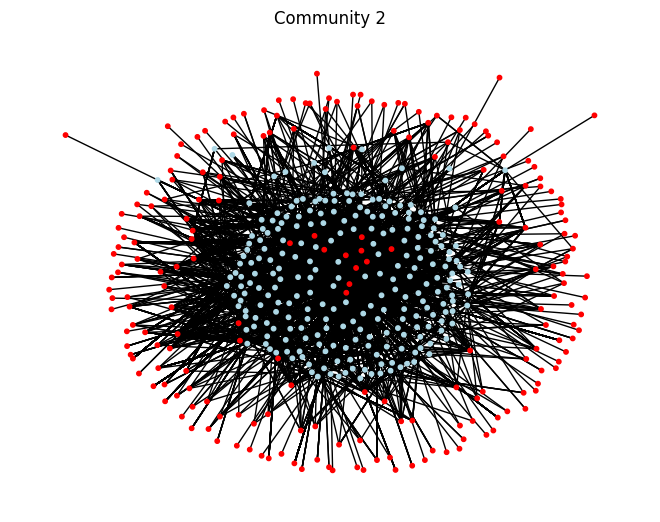

Community 3:
 Central Features (In-Degree Centrality):
  Node: 5234, In-Degree Centrality: 39.90944881889764
  Node: 2185, In-Degree Centrality: 8.826771653543307
  Node: 2763, In-Degree Centrality: 2.637795275590551
  Node: 9203, In-Degree Centrality: 1.4133858267716535
  Node: 8372, In-Degree Centrality: 1.2283464566929134
 Central Motifs (Out-Degree Centrality):
  Node: CCAGCC, Out-Degree Centrality: 1.9094488188976377
  Node: CCCAGC, Out-Degree Centrality: 1.8070866141732282
  Node: CAGCCC, Out-Degree Centrality: 1.7834645669291338
  Node: GCAGCC, Out-Degree Centrality: 1.5511811023622046
  Node: GCCACC, Out-Degree Centrality: 1.330708661417323


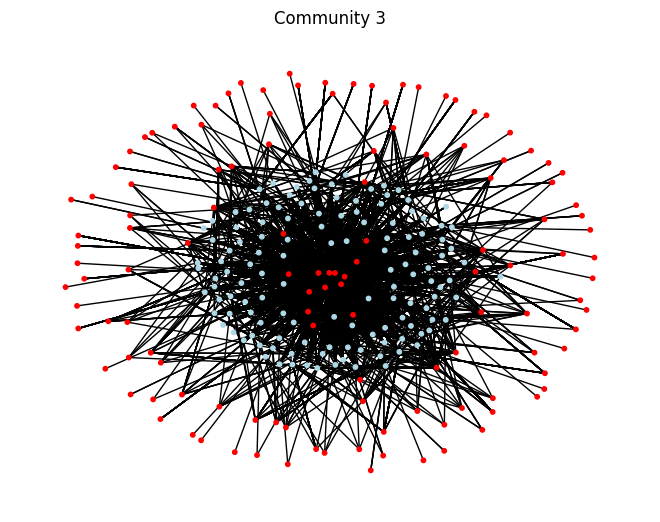

Community 4:
 Central Features (In-Degree Centrality):
  Node: 2558, In-Degree Centrality: 25.606145251396647
  Node: 8596, In-Degree Centrality: 0.9860335195530726
  Node: 9128, In-Degree Centrality: 0.7150837988826816
  Node: 10175, In-Degree Centrality: 0.2681564245810056
  Node: 2528, In-Degree Centrality: 0.15921787709497207
 Central Motifs (Out-Degree Centrality):
  Node: GCGGCG, Out-Degree Centrality: 0.4357541899441341
  Node: GCCGGG, Out-Degree Centrality: 0.4301675977653631
  Node: GCTGCA, Out-Degree Centrality: 0.4273743016759777
  Node: CCGCGC, Out-Degree Centrality: 0.38268156424581007
  Node: CTGAGG, Out-Degree Centrality: 0.37988826815642457


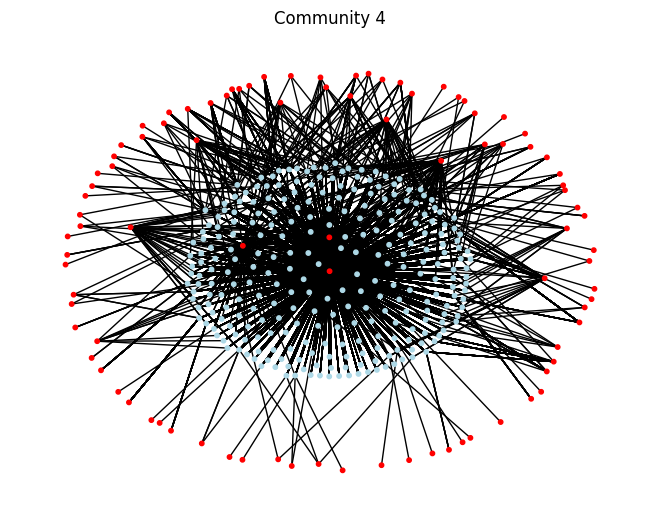

Community 5:
 Central Features (In-Degree Centrality):
  Node: 6445, In-Degree Centrality: 20.486713286713286
  Node: 460, In-Degree Centrality: 6.9944055944055945
  Node: 9656, In-Degree Centrality: 4.623776223776224
  Node: 2416, In-Degree Centrality: 3.4503496503496502
  Node: 4554, In-Degree Centrality: 2.537062937062937
 Central Motifs (Out-Degree Centrality):
  Node: GAGGAG, Out-Degree Centrality: 0.8237762237762237
  Node: GGAGGA, Out-Degree Centrality: 0.8111888111888111
  Node: GGGAGG, Out-Degree Centrality: 0.7384615384615385
  Node: AGGAGG, Out-Degree Centrality: 0.676923076923077
  Node: GGAGGG, Out-Degree Centrality: 0.586013986013986


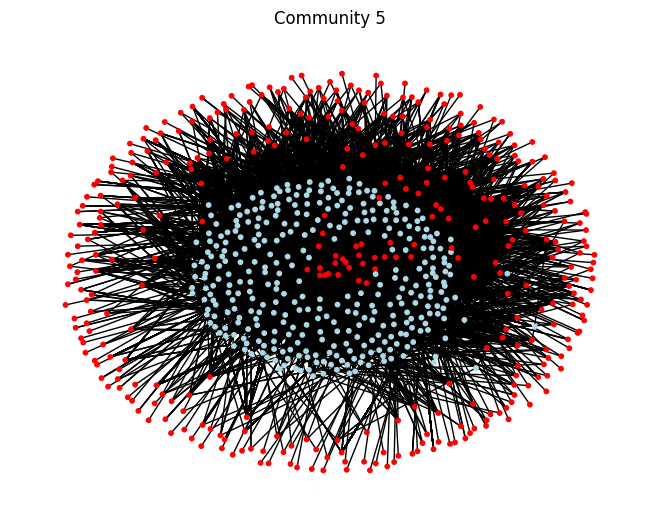

Community 6:
 Central Features (In-Degree Centrality):
  Node: 9685, In-Degree Centrality: 5.636986301369863
  Node: 8220, In-Degree Centrality: 4.013698630136986
  Node: 9853, In-Degree Centrality: 0.9452054794520548
  Node: 8413, In-Degree Centrality: 0.8150684931506849
  Node: 7345, In-Degree Centrality: 0.5136986301369862
 Central Motifs (Out-Degree Centrality):
  Node: ACCCCC, Out-Degree Centrality: 0.636986301369863
  Node: CACCAC, Out-Degree Centrality: 0.5821917808219178
  Node: CCACAC, Out-Degree Centrality: 0.5616438356164384
  Node: CACCCC, Out-Degree Centrality: 0.547945205479452
  Node: CAAAGT, Out-Degree Centrality: 0.4520547945205479


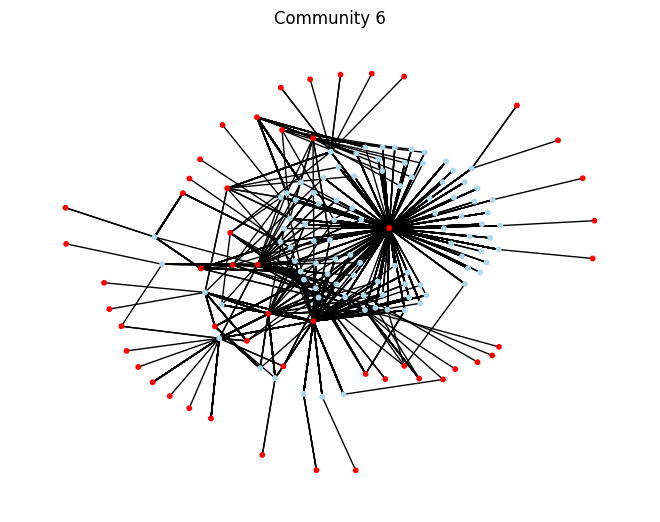

Community 7:
 Central Features (In-Degree Centrality):
  Node: 407, In-Degree Centrality: 103.78372093023256
  Node: 6296, In-Degree Centrality: 12.941860465116278
  Node: 835, In-Degree Centrality: 6.723255813953489
  Node: 7949, In-Degree Centrality: 5.481395348837209
  Node: 1235, In-Degree Centrality: 4.286046511627907
 Central Motifs (Out-Degree Centrality):
  Node: G, Out-Degree Centrality: 35.14418604651163
  Node: C, Out-Degree Centrality: 34.73720930232558
  Node: T, Out-Degree Centrality: 34.16046511627907
  Node: A, Out-Degree Centrality: 30.611627906976743
  Node: CCGCCG, Out-Degree Centrality: 0.8046511627906977


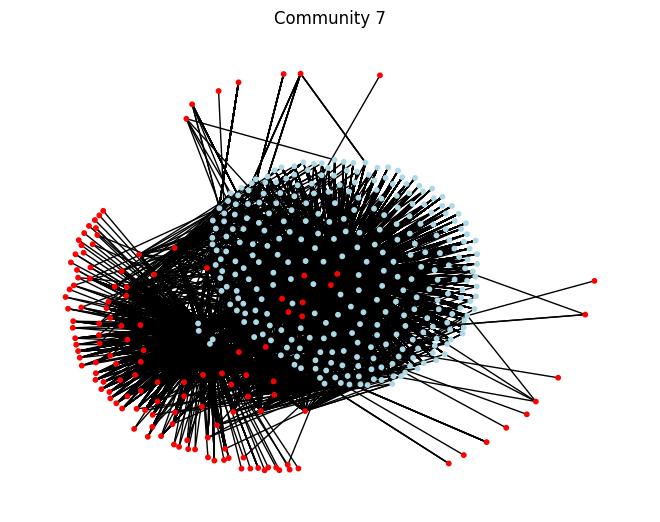

Community 8:
 Central Features (In-Degree Centrality):
  Node: 1895, In-Degree Centrality: 10.734939759036145
  Node: 2953, In-Degree Centrality: 4.849397590361446
  Node: 1371, In-Degree Centrality: 3.0843373493975905
  Node: 1977, In-Degree Centrality: 0.46385542168674704
  Node: 2496, In-Degree Centrality: 0.14457831325301207
 Central Motifs (Out-Degree Centrality):
  Node: GGCGGC, Out-Degree Centrality: 1.0843373493975905
  Node: CGCCCG, Out-Degree Centrality: 0.6144578313253012
  Node: AGTGGC, Out-Degree Centrality: 0.45783132530120485
  Node: ATGGCT, Out-Degree Centrality: 0.43975903614457834
  Node: ATGGCG, Out-Degree Centrality: 0.43373493975903615


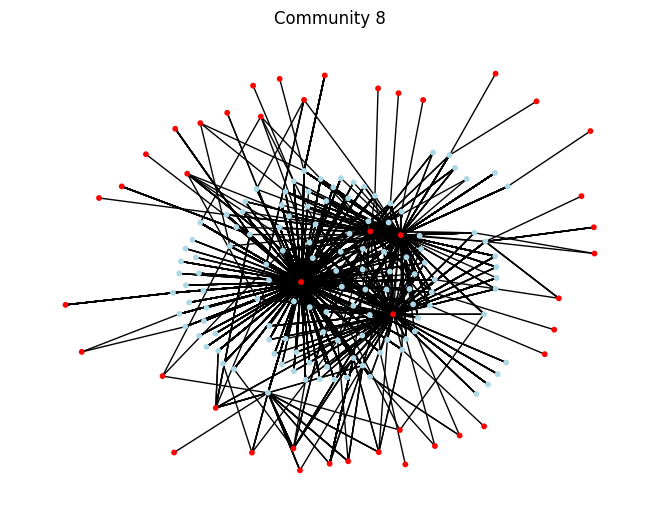

Community 9:
 Central Features (In-Degree Centrality):
  Node: 1545, In-Degree Centrality: 12.0
  Node: 10234, In-Degree Centrality: 5.232558139534883
  Node: 5503, In-Degree Centrality: 1.9578488372093024
  Node: 1321, In-Degree Centrality: 1.188953488372093
  Node: 1160, In-Degree Centrality: 1.181686046511628
 Central Motifs (Out-Degree Centrality):
  Node: GGCCTC, Out-Degree Centrality: 0.2558139534883721
  Node: GGCTGC, Out-Degree Centrality: 0.24127906976744184
  Node: GACCTC, Out-Degree Centrality: 0.22965116279069767
  Node: TGACCT, Out-Degree Centrality: 0.1933139534883721
  Node: GGACCC, Out-Degree Centrality: 0.18023255813953487


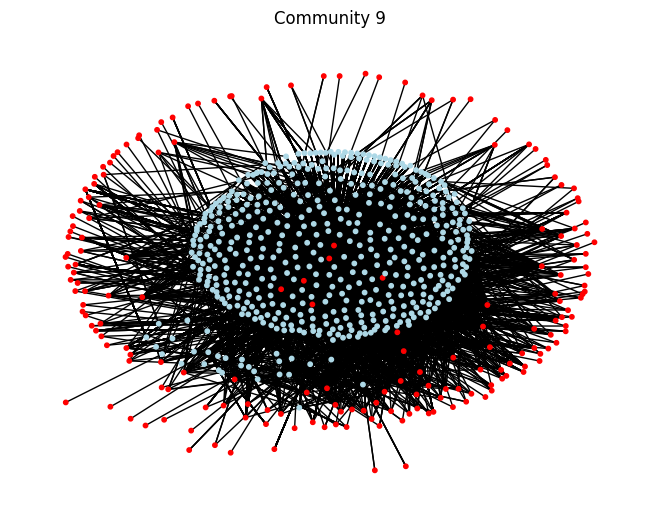

Community 10:
 Central Features (In-Degree Centrality):
  Node: 4014, In-Degree Centrality: 20.204326923076923
  Node: 1080, In-Degree Centrality: 2.9423076923076925
  Node: 1802, In-Degree Centrality: 1.466346153846154
  Node: 5693, In-Degree Centrality: 0.8365384615384616
  Node: 3776, In-Degree Centrality: 0.7307692307692308
 Central Motifs (Out-Degree Centrality):
  Node: CAGCCT, Out-Degree Centrality: 0.8245192307692308
  Node: GGCTGG, Out-Degree Centrality: 0.8173076923076924
  Node: TGGCCT, Out-Degree Centrality: 0.5985576923076923
  Node: GGCCAG, Out-Degree Centrality: 0.5913461538461539
  Node: GCTGGG, Out-Degree Centrality: 0.5504807692307693


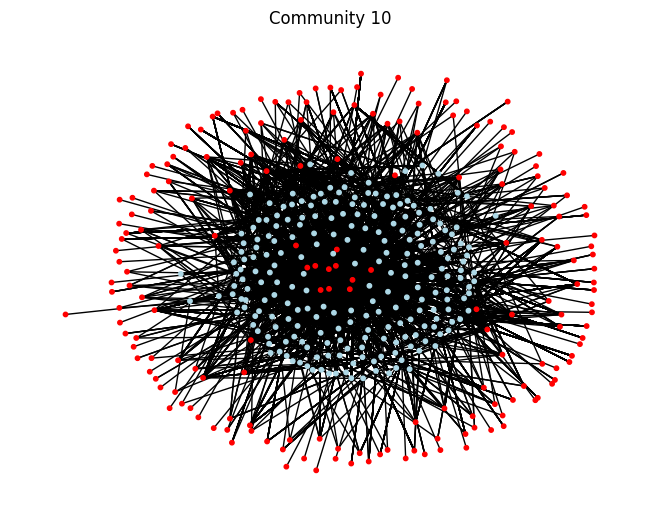

Community 11:
 Central Features (In-Degree Centrality):
  Node: 5458, In-Degree Centrality: 213.0
  Node: GTGTGT, In-Degree Centrality: 0.0
  Node: TGTGTG, In-Degree Centrality: 0.0
 Central Motifs (Out-Degree Centrality):
  Node: TGTGTG, Out-Degree Centrality: 127.5
  Node: GTGTGT, Out-Degree Centrality: 85.5
  Node: 5458, Out-Degree Centrality: 0.0


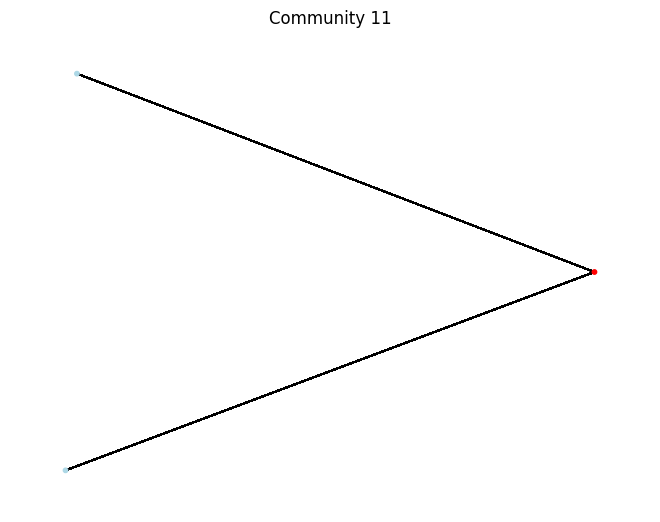

Community 12:
 Central Features (In-Degree Centrality):
  Node: 4793, In-Degree Centrality: 23.174630755864463
  Node: 2471, In-Degree Centrality: 1.0304083405734143
  Node: 1317, In-Degree Centrality: 0.841007819287576
  Node: 2985, In-Degree Centrality: 0.5091225021720243
  Node: 6165, In-Degree Centrality: 0.3466550825369244
 Central Motifs (Out-Degree Centrality):
  Node: CTGTGG, Out-Degree Centrality: 0.17028670721112074
  Node: GAGTGC, Out-Degree Centrality: 0.13727193744569938
  Node: CAGTGG, Out-Degree Centrality: 0.1311902693310165
  Node: TGAAGA, Out-Degree Centrality: 0.12250217202432667
  Node: CACTGA, Out-Degree Centrality: 0.11815812337098175


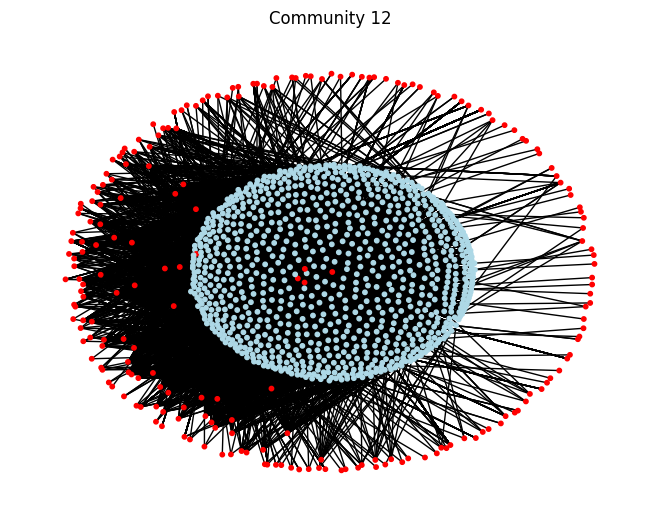

Community 13:
 Central Features (In-Degree Centrality):
  Node: 238, In-Degree Centrality: 8.266666666666666
  Node: 7823, In-Degree Centrality: 4.066666666666666
  Node: 3255, In-Degree Centrality: 2.533333333333333
  Node: 396, In-Degree Centrality: 1.7333333333333334
  Node: 1271, In-Degree Centrality: 1.3333333333333333
 Central Motifs (Out-Degree Centrality):
  Node: CACTGC, Out-Degree Centrality: 8.133333333333333
  Node: GCTGCT, Out-Degree Centrality: 4.266666666666667
  Node: TCAAGC, Out-Degree Centrality: 3.8
  Node: TGCTGC, Out-Degree Centrality: 1.7333333333333334
  Node: ACTCTG, Out-Degree Centrality: 0.9333333333333333


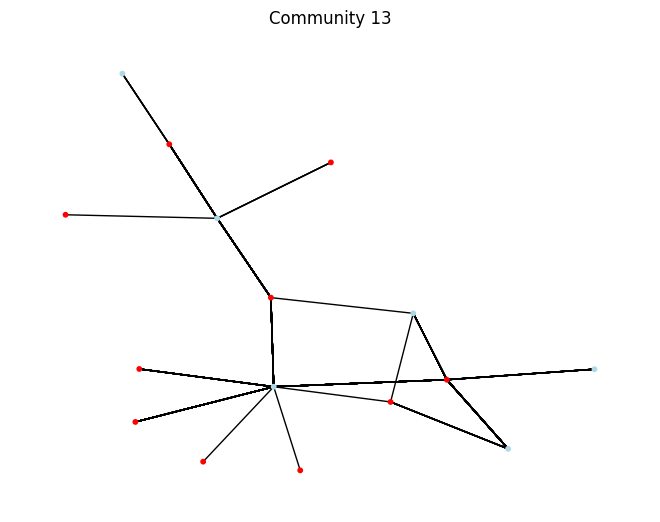

Community 14:
 Central Features (In-Degree Centrality):
  Node: 8707, In-Degree Centrality: 15.22140221402214
  Node: 4137, In-Degree Centrality: 6.129151291512915
  Node: 7834, In-Degree Centrality: 0.47232472324723246
  Node: 771, In-Degree Centrality: 0.4280442804428044
  Node: 9686, In-Degree Centrality: 0.36900369003690037
 Central Motifs (Out-Degree Centrality):
  Node: GCAGTG, Out-Degree Centrality: 0.6162361623616236
  Node: CCTGGG, Out-Degree Centrality: 0.5276752767527675
  Node: GGTGTG, Out-Degree Centrality: 0.5202952029520295
  Node: TGTGGG, Out-Degree Centrality: 0.5092250922509225
  Node: GCCTGG, Out-Degree Centrality: 0.49815498154981547


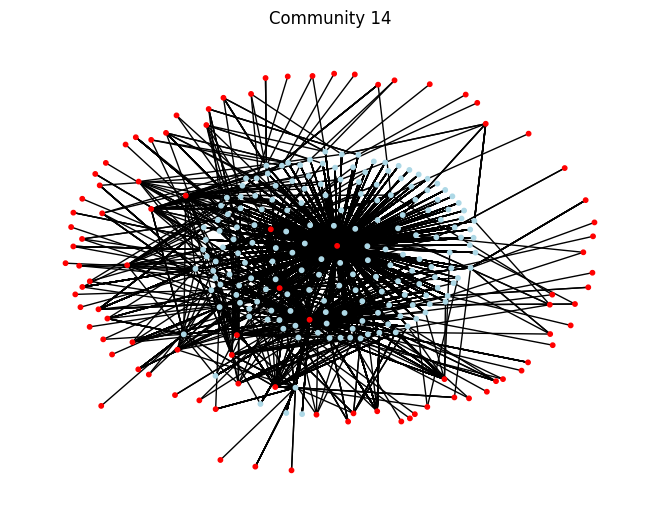

Community 15:
 Central Features (In-Degree Centrality):
  Node: 7030, In-Degree Centrality: 4.705263157894737
  Node: 4831, In-Degree Centrality: 4.575438596491228
  Node: 2996, In-Degree Centrality: 3.7333333333333334
  Node: 9148, In-Degree Centrality: 3.2350877192982455
  Node: 1781, In-Degree Centrality: 1.736842105263158
 Central Motifs (Out-Degree Centrality):
  Node: TTTTTT, Out-Degree Centrality: 2.550877192982456
  Node: AAAAAA, Out-Degree Centrality: 1.3789473684210527
  Node: AGAAAA, Out-Degree Centrality: 1.0035087719298246
  Node: TTTCTT, Out-Degree Centrality: 0.7368421052631579
  Node: ATTTTT, Out-Degree Centrality: 0.712280701754386


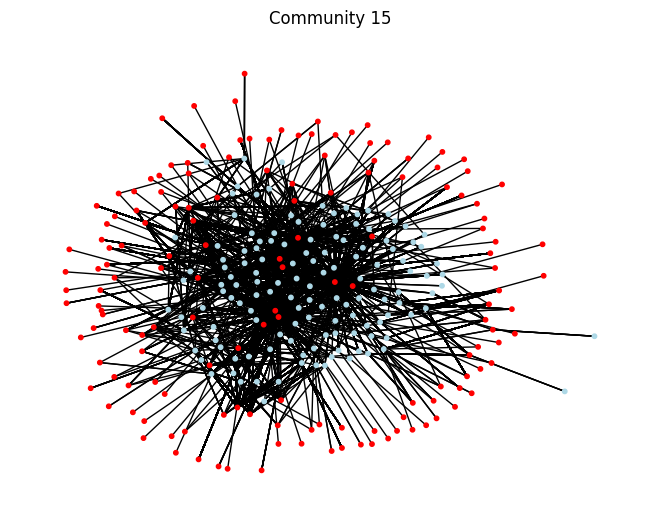

Community 16:
 Central Features (In-Degree Centrality):
  Node: 1017, In-Degree Centrality: 5.928571428571428
  Node: 9291, In-Degree Centrality: 5.285714285714286
  Node: 3898, In-Degree Centrality: 1.4285714285714284
  Node: 171, In-Degree Centrality: 0.7142857142857142
  Node: 9197, In-Degree Centrality: 0.3571428571428571
 Central Motifs (Out-Degree Centrality):
  Node: TTACAG, Out-Degree Centrality: 6.2142857142857135
  Node: AAAGTG, Out-Degree Centrality: 4.928571428571428
  Node: GAGTAG, Out-Degree Centrality: 3.2857142857142856
  Node: 6085, Out-Degree Centrality: 0.0
  Node: 171, Out-Degree Centrality: 0.0


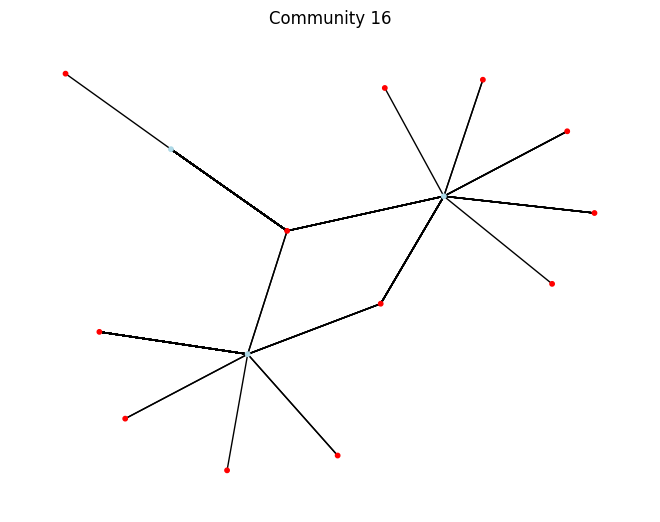

Community 17:
 Central Features (In-Degree Centrality):
  Node: 1399, In-Degree Centrality: 10.0
  Node: TACTCG, In-Degree Centrality: 0.0
 Central Motifs (Out-Degree Centrality):
  Node: TACTCG, Out-Degree Centrality: 10.0
  Node: 1399, Out-Degree Centrality: 0.0


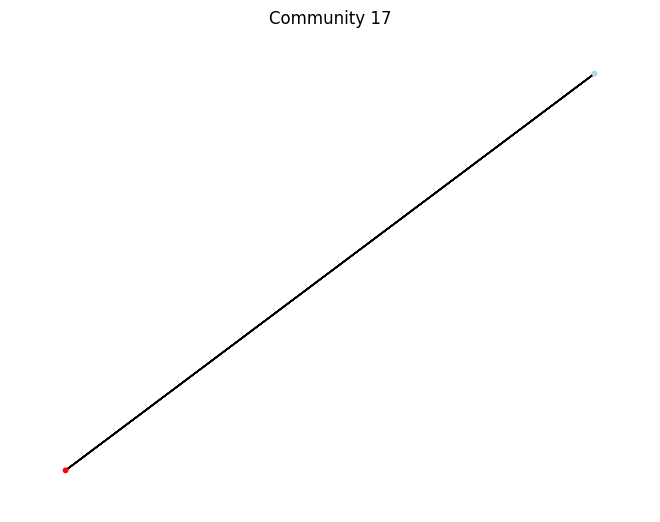

In [24]:
subgraph_list = []
for i, c in enumerate(communities):
    graph = OG.subgraph(c)
    central_features = sorted(nx.in_degree_centrality(graph).items(), key=lambda x: x[1], reverse=True)[:5]
    central_motifs = sorted(nx.out_degree_centrality(graph).items(), key=lambda x: x[1], reverse=True)[:5]

    print(f"Community {i}:")
    print(" Central Features (In-Degree Centrality):")
    for node, cent in central_features:
        print(f"  Node: {node}, In-Degree Centrality: {cent}")
    print(" Central Motifs (Out-Degree Centrality):")
    for node, cent in central_motifs:
        print(f"  Node: {node}, Out-Degree Centrality: {cent}")
    graph = graph.to_undirected()

    # Export each community to a separate JSON file
    if not os.path.exists(f"data/KG_louvain_communities/{i}"):
        os.makedirs(f"data/KG_louvain_communities/{i}", exist_ok=True)
    with open(f"data/KG_louvain_communities/{i}/graph.json", "w") as f:
        json.dump(json_graph.node_link_data(graph, edges="edges"), f)

    subgraph_list.append({"g":graph, "central_feat": central_features[0], "central_motif": central_motifs[0]})

    # Visualize the community
    nx.draw(graph, pos=nx.kamada_kawai_layout(graph), with_labels=False, node_size=10, font_size=4, node_color=[node_color(n) for n in graph.nodes()])
    plt.title(f"Community {i}")
    plt.show()

In [29]:
# generate gene sets for central features and motifs in each community
for i, sub in enumerate(subgraph_list):
    graph = sub["g"]
    central_feat = sub["central_feat"][0]
    central_motif = sub["central_motif"][0]

    # central feature
    if type(central_feat) == int:
        edges = graph.edges(central_feat, data="annotations")
        genes = []
        motifs = []
        for u, v, annotations in edges:
            for key, val in annotations.items():
                motif = u if u != central_feat else v
                genes.append(val["gene_id"])
                motifs.append(motif)
        with open(f"data/KG_louvain_communities/{i}/feature_{central_feat}_genes.txt", "w") as f:
            f.writelines((set(genes)))
        with open(f"data/KG_louvain_communities/{i}/feature_{central_feat}_motifs.txt", "w") as f:
            f.writelines((set(motifs)))

    # central motif
    if type(central_motif) == str:
        edges = graph.edges(central_motif, data="annotations")
        genes = []
        features = []
        for u, v, annotations in edges:
            for key, val in annotations.items():
                feature = u if u != central_motif else v
                genes.append(val["gene_id"])
                features.append(str(feature))
        with open(f"data/KG_louvain_communities/{i}/motif_{central_motif}_genes.txt", "w") as f:
            f.writelines((set(genes)))
        with open(f"data/KG_louvain_communities/{i}/motif_{central_motif}_features.txt", "w") as f:
            f.writelines((set(features)))